# Mult-VAE

- [Variational Autoencoders for Collaborative Filtering](https://arxiv.org/pdf/1802.05814.pdf)
- [참고](https://jrzaurin.github.io/infinitoml/2020/05/15/mult-vae.html)

## Experiment

- sampling vs training all
     - sampling이 일반적으로 성능이 좋음
- alternative learning
    - alternative learning으로 성능 향상
- multinomial vs logistic
    - alternative learning을 적용하지 않으면 logistic의 성능이 더 좋았음
    - alternative learning을 적용하게 되면 multinomial의 성능이 더 좋아짐
- Mult-VAE vs Mult-DAE
    - ML-1m에서는 Mult-DAE 성능이 더 높았음

In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple, List

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''

    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    elif data_size == '25m':
        file = get_file('ml-25m.zip', 'http://files.grouplens.org/datasets/movielens/ml-25m.zip')
        file_name = 'ml-25m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    if data_size in ['20m', '25m']:
        ratings = pd.read_csv(file_name, engine = 'python')
    else:
        ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

5922816/5917549 [==============================] - 1s 0us/step
(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
def preprocessing(df: pd.DataFrame, threshold = 4) -> pd.DataFrame:
    df = df[df.rating >= threshold]
    positive = df.groupby('userId')['movieId'].nunique()
    positive = positive.index[positive >= 5]
    df = df[df.userId.isin(positive)]
    return df.reset_index(drop = True)

In [5]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(f'# of user = {n_user}')

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [6]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [7]:
ratings = preprocessing(ratings)
ratings = Id2idx(ratings)

print(ratings.shape)
ratings.head(5)

(575272, 4)


,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,3,4,978300275
2,0,4,5,978824291
3,0,6,5,978302039
4,0,7,5,978300719


In [8]:
def train_valid_test_split(df: pd.DataFrame) -> pd.DataFrame:
    train_user, test_user = train_test_split(df.userId.unique(), test_size = 0.2, random_state = 7777)
    valid_user, test_user = train_test_split(test_user, test_size = 0.5, random_state = 7777)

    train, valid, test = map(lambda x: df[df.userId.isin(x)], (train_user, valid_user, test_user))
    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    return train, valid, test

def query_answer_split(df: pd.DataFrame) -> pd.DataFrame:
    query, answer = train_test_split(df, test_size = 0.2, stratify = df.userId, random_state = 7777)
    query, answer = map(lambda df: df.sort_values(['userId', 'timestamp']), (query, answer))
    query, answer = map(lambda df: df.reset_index(drop = True), (query, answer))
    return query, answer

def list_aggregation(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

In [9]:
def train_generator(df: pd.DataFrame,
                    n_item: int,
                    batch_size: int,
                    implicit = True,
                    threshold = 4,
                    corruption = 0.5,
                    sampling = True,
                    NS = 5) -> Tuple[np.array, np.array]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    if sampling:
        while True:
            batch_Id = np.random.choice(Ids, size = batch_size)
            batch = np.zeros(shape = (batch_size, n_col))
            
            for i, idx in enumerate(batch_Id):
                pos = np.array(profile[idx])
                batch[i, pos] = rating[idx]

            yield batch, batch
    else:
        while True:
            np.random.shuffle(Ids)
        
            for batch_step in range(n_batch):
                lower = batch_step * batch_size
                upper = lower + batch_size
                
                batch_Id = Ids[lower: upper]
                batch = np.zeros(shape = (batch_Id.size, n_col))
                for i, idx in enumerate(batch_Id):
                    pos = np.array(profile[idx])
                    batch[i, pos] = rating[idx]              
                yield batch, batch

In [10]:
def valid_generator(query: pd.DataFrame,
                    answer: pd.DataFrame,
                    n_item: int,
                    batch_size: int,
                    implicit = True,
                    threshold = 4) -> Tuple[np.array, np.array]:

    n_row = query.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile_q = query['movieId']
    profile_a = answer['movieId']
    if implicit:
        rating_q = query['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])
        rating_a = answer['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])
    else:
        rating_q = query['rating']
        rating_a = answer['rating']

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch_q = np.zeros(shape = (batch_Id.size, n_col))
            batch_a = np.zeros(shape = (batch_Id.size, n_col))

            for i, idx in enumerate(batch_Id):
                obs = np.array(profile_q[idx]) # observed
                ubs = np.array(profile_a[idx]) # unobserved

                batch_q[i, obs] = rating_q[idx]
                batch_a[i, ubs] = rating_a[idx]

            yield batch_q, batch_a

In [11]:
def mae(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    ae = K.abs(y_true - y_pred)
    return K.mean(ae, axis = -1)

def rmse(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    se = K.square(mask_true * (y_true - y_pred))
    return K.sqrt(K.mean(masked_se, axis = -1))

def cross_entropy(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    ce = y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)
    return -K.sum(ce, axis = -1)

def log_loss(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    return -K.sum(y_true * K.log(y_pred), axis = -1)

def batch_ndcg(y_true, y_pred, k = 100):
    rec = tf.argsort(y_pred, axis = -1, direction = 'DESCENDING')[:, :k]

    row = tf.repeat(tf.range(tf.shape(y_true)[0]), k)
    row = tf.expand_dims(row, axis = 1)
    col = tf.reshape(rec, shape = [-1])
    col = tf.expand_dims(col, axis = 1)
    loc = tf.concat([row, col], axis = 1)

    top_k = tf.reshape(tf.gather_nd(y_true, loc), shape = tf.shape(rec))
    ideal = tf.sort(top_k, axis = 1, direction = 'DESCENDING')

    weight = tf.range(2, 102, dtype = 'float32')
    weight = tf.math.log(weight)
    weight = tf.math.reciprocal(weight)
    
    dcg = tf.reduce_sum(top_k * weight, axis = 1)    
    idcg = tf.reduce_sum(ideal * weight, axis = 1)
    return dcg / tf.where(idcg == 0, 1.0, idcg)

In [12]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        return z_mean + K.exp(0.5 * z_log_var) * K.random_normal(shape = (batch, dim))

In [13]:
def VAE(n_user: int,
        n_item: int,
        latent_dim = 200,
        activation = 'tanh',
        enc_optimizer = 'adam',
        optimizer = 'adam',
        dropout_rate = 0.5,
        kernel_initializer = None,
        likelihood = 'logistic',
        beta = 0.2) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)

    if likelihood == 'multinomial':
        loss = log_loss
        last_activation = 'softmax'
    elif likelihood == 'logistic':
        loss = cross_entropy
        last_activation = 'sigmoid'
    elif likelihood == 'gaussian':
        loss = rmse
        last_activation = 'sigmoid'
    
    inputs = Input(shape = (n_item, ), name = 'input')
    z_mean_weight = Dense(latent_dim,
                          activation = activation,
                          kernel_initializer = kernel_initializer,
                          name = 'mean')
    z_log_var_weight = Dense(latent_dim, 
                             activation = activation,
                             kernel_initializer = kernel_initializer,
                             name = 'log_var')
    outputs_weight = Dense(n_item,
                           activation = last_activation, 
                           kernel_initializer = kernel_initializer,
                           name = 'output')

    x = Dropout(dropout_rate)(inputs)
    enc_z_mean = z_mean_weight(x)
    enc_z_log_var = z_log_var_weight(x)
    enc_z = Sampling()([enc_z_mean, enc_z_log_var])
    enc_KLD = -0.5 * K.sum(1 + enc_z_log_var - K.exp(enc_z_log_var) - K.square(enc_z_mean), axis = -1)
    encoder_loss = K.mean(enc_KLD, axis = -1)

    encoder = Model(inputs = inputs, outputs = [enc_z_mean, enc_z_log_var, enc_z], name = 'encoder')
    encoder.add_loss(encoder_loss)
    encoder.compile(optimizer = enc_optimizer)

    z_mean = z_mean_weight(inputs)
    z_log_var = z_log_var_weight(inputs)
    z = Sampling()([z_mean, z_log_var])
    outputs = outputs_weight(z)

    KLD = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis = -1)
    MLE = loss(inputs, outputs)
    vae_loss = K.mean(MLE + beta * KLD, axis = -1)

    model = Model(inputs = inputs, outputs = outputs, name = 'VAE')
    model.add_loss(vae_loss)
    model.compile(optimizer = optimizer, metrics = [mae, batch_ndcg])
    return encoder, model

In [14]:
def test_predictor(df: pd.DataFrame, 
                   model: Callable, 
                   n_item: int, 
                   batch_size: int, 
                   implicit = True,
                   threshold = 4,
                   top_N = 20) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])

    res = []
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = rating[idx]

        y_pred = model.predict(y_true, verbose = 0)
        
        rec = np.argsort(np.where(y_true == 1, -1, y_pred), axis = -1)[:, :-top_N-1:-1]
        res.append(rec)
    return np.concatenate(res)

In [15]:
def show_history(history, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(history[f'{loss}'])
    ax1.plot(history[f'val_{loss}'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(history[f'{metric}'])
    ax2.plot(history[f'val_{metric}'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['metric', 'metric'], loc = 'upper right')
    plt.show()

In [16]:
def ndcg(gt, rec):
    dcg, idcg = 0.0, 0.0
    k = 0
    for i, r in enumerate(rec):
        if r in gt:
            dcg += 1.0 / np.log(i + 2)
            idcg += 1.0 / np.log(k + 2)
            k += 1
    return dcg / np.max([1, idcg])

def recall(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(gt)

def precision(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(rec)

def precision_k(gt, rec, k):
    rec_k = rec[:k+1]
    res = [r for r in rec_k if r in gt]
    return len(res) / k

def AP_k(gt, rec, k = 20):
    res = 0
    for i in range(k):
        if rec[i] in gt:
            res += precision_k(gt, rec, i+1)
    return res / min(k, len(gt))

In [17]:
def evaluation(true: pd.DataFrame, pred):
    m_ndcg = 0
    m_recall = 0
    m_precision = 0
    map_k = 0
    for i in range(len(pred)):
        rec = pred[i]
        gt = true.at[i, 'movieId']
        m_ndcg += ndcg(gt, rec)
        m_recall += recall(gt, rec)
        m_precision += precision(gt, rec)
        map_k += AP_k(gt, rec)
    m_ndcg /= len(pred)
    m_recall /= len(pred)
    m_precision /= len(pred)
    map_k /= len(pred)
    return m_ndcg, m_recall, m_precision, map_k

### 1. Mult-DAE(Multinomial Likelihood)

In [18]:
batch_size = 128

train, valid, test = train_valid_test_split(ratings)
(valid_q, valid_a), (test_q, test_a) = map(query_answer_split, (valid, test))
train, valid_q, valid_a, test_q, test_a = map(list_aggregation, (train, valid_q, valid_a, test_q, test_a))

train_gen = train_generator(train, n_item, batch_size)
valid_gen = valid_generator(valid_q, valid_a, n_item, batch_size)

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid_q.index.size // batch_size + 1

In [19]:
enc_optimizer = RMSprop(learning_rate = 0.001, decay = 1e-5)
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
encoder, model = VAE(n_user, n_item, latent_dim = 200, enc_optimizer = enc_optimizer, optimizer = optimizer, likelihood = 'multinomial')
model.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
mean (Dense)                    (None, 200)          741400      input[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 200)          741400      input[0][0]                      
__________________________________________________________________________________________________
sampling_1 (Sampling)           (None, 200)          0           mean[1][0]                       
                                                                 log_var[1][0]                  

In [20]:
%%time
epochs = 100
total_hist = {}
for _ in range(epochs):
    anneal_size, epoch_size = 6, 4
    encoder.fit(x = train_gen, epochs = anneal_size, steps_per_epoch = steps_per_epoch, verbose = 0)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epoch_size, verbose = 1,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps)
    for key in hist.history.keys():
        total_hist[key] = total_hist.get(key, []) + hist.history[key]

Epoch 1/4
38/38 [==============================] - 1s 23ms/step - loss: 753.3041 - mae: 0.0264 - batch_ndcg: 0.4798 - val_loss: 543.7399 - val_mae: 0.0052 - val_batch_ndcg: 0.2944
Epoch 2/4
38/38 [==============================] - 1s 16ms/step - loss: 689.6307 - mae: 0.0257 - batch_ndcg: 0.6469 - val_loss: 528.3854 - val_mae: 0.0052 - val_batch_ndcg: 0.3307
Epoch 3/4
38/38 [==============================] - 1s 16ms/step - loss: 685.1906 - mae: 0.0261 - batch_ndcg: 0.7028 - val_loss: 519.0959 - val_mae: 0.0052 - val_batch_ndcg: 0.3485
Epoch 4/4
38/38 [==============================] - 1s 16ms/step - loss: 677.7238 - mae: 0.0263 - batch_ndcg: 0.7525 - val_loss: 512.9878 - val_mae: 0.0052 - val_batch_ndcg: 0.3548
Epoch 1/4
38/38 [==============================] - 1s 15ms/step - loss: 686.4018 - mae: 0.0255 - batch_ndcg: 0.5923 - val_loss: 520.5255 - val_mae: 0.0052 - val_batch_ndcg: 0.3357
Epoch 2/4
38/38 [==============================] - 1s 16ms/step - loss: 678.6249 - mae: 0.0262 - bat

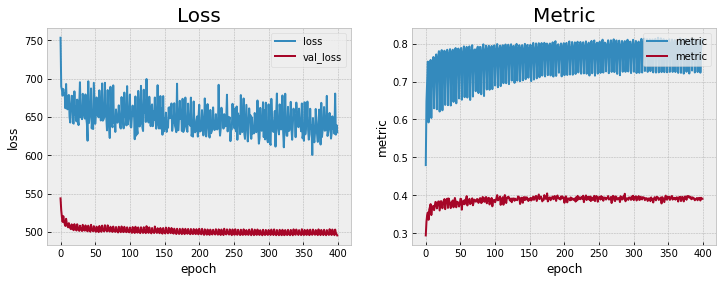

In [21]:
show_history(total_hist, 'loss', 'batch_ndcg')

In [22]:
pred = test_predictor(test_q, model, n_item, batch_size)
pred

array([[ 992,   10, 2538, ..., 2043,  113,  519],
       [ 676,   22, 1509, ..., 1575,  814,   60],
       [ 317,  128,  788, ...,  164,   69,   97],
       ...,
       [ 434,  669,    0, ..., 1730,  167, 1233],
       [ 420,  719, 1001, ...,    0,    5, 1240],
       [1446,   44,  960, ...,    5,  748, 2121]])

In [23]:
m_ndcg, m_recall, m_precision, map_k = evaluation(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.52462 
Recall: 0.21799 
Precision: 0.17070 
MAP: 0.13250


### 2. Mult-DAE(Logistic)

In [24]:
enc_optimizer = RMSprop(learning_rate = 0.001, decay = 1e-5)
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
encoder, model = VAE(n_user, n_item, latent_dim = 200, enc_optimizer = enc_optimizer, optimizer = optimizer, likelihood = 'logistic')
model.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
mean (Dense)                    (None, 200)          741400      input[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 200)          741400      input[0][0]                      
__________________________________________________________________________________________________
sampling_3 (Sampling)           (None, 200)          0           mean[1][0]                       
                                                                 log_var[1][0]                  

In [25]:
%%time
epochs = 100
total_hist = {}
for _ in range(epochs):
    anneal_size, epoch_size = 8, 4
    encoder.fit(x = train_gen, epochs = anneal_size, steps_per_epoch = steps_per_epoch, verbose = 0)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epoch_size, verbose = 1,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps)
    for key in hist.history.keys():
        total_hist[key] = total_hist.get(key, []) + hist.history[key]

Epoch 1/4
38/38 [==============================] - 1s 23ms/step - loss: 1319.1676 - mae: 0.2437 - batch_ndcg: 0.4579 - val_loss: 498.9506 - val_mae: 0.0676 - val_batch_ndcg: 0.3160
Epoch 2/4
38/38 [==============================] - 1s 17ms/step - loss: 463.3389 - mae: 0.0593 - batch_ndcg: 0.6217 - val_loss: 402.9334 - val_mae: 0.0479 - val_batch_ndcg: 0.3289
Epoch 3/4
38/38 [==============================] - 1s 17ms/step - loss: 425.0295 - mae: 0.0536 - batch_ndcg: 0.6317 - val_loss: 383.0962 - val_mae: 0.0446 - val_batch_ndcg: 0.3209
Epoch 4/4
38/38 [==============================] - 1s 16ms/step - loss: 413.5061 - mae: 0.0518 - batch_ndcg: 0.6365 - val_loss: 364.6105 - val_mae: 0.0423 - val_batch_ndcg: 0.3345
Epoch 1/4
38/38 [==============================] - 1s 17ms/step - loss: 715.3528 - mae: 0.1130 - batch_ndcg: 0.5619 - val_loss: 434.5039 - val_mae: 0.0531 - val_batch_ndcg: 0.3247
Epoch 2/4
38/38 [==============================] - 1s 16ms/step - loss: 436.5191 - mae: 0.0555 - ba

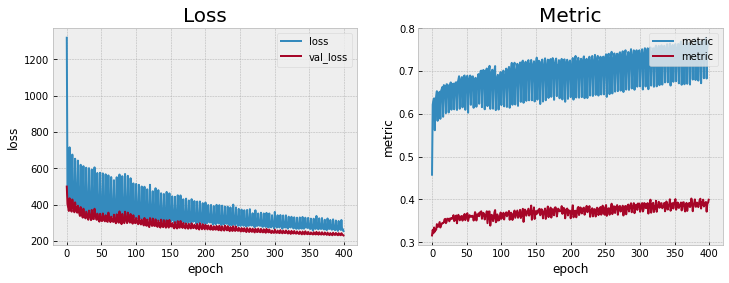

In [26]:
show_history(total_hist, 'loss', 'batch_ndcg')

In [27]:
pred = test_predictor(test_q, model, n_item, batch_size)
pred

array([[171, 729,   9, ..., 128,  92,  19],
       [ 22,  33, 733, ..., 814,  38, 160],
       [128, 167, 317, ..., 246,  97, 541],
       ...,
       [611, 662,  44, ..., 718,  96, 127],
       [104, 420,  23, ...,  50, 661, 531],
       [ 44, 127, 420, ...,  22, 113, 559]])

In [28]:
m_ndcg, m_recall, m_precision, map_k = evaluation(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.52840 
Recall: 0.20719 
Precision: 0.17310 
MAP: 0.14501


### 3. Mult-DAE

In [29]:
def DAE(n_user: int,
        n_item: int,
        latent_dim = 200,
        activation = 'tanh',
        optimizer = 'adam',
        dropout_rate = 0.5,
        kernel_initializer = None,
        kernel_regularizer = None) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
    
    inputs = x = Input(shape = (n_item, ), name = 'input')
    x = Dropout(dropout_rate)(x)
    x = Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'encoder')(x)
    outputs = Dense(n_item, activation = 'softmax', kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'decoder')(x)
    model = Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = optimizer, loss = log_loss, metrics = batch_ndcg)
    return model

In [34]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
model = DAE(n_user, n_item, latent_dim = 200, optimizer = optimizer)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3706)              0         
_________________________________________________________________
encoder (Dense)              (None, 200)               741400    
_________________________________________________________________
decoder (Dense)              (None, 3706)              744906    
Total params: 1,486,306
Trainable params: 1,486,306
Non-trainable params: 0
_________________________________________________________________


In [35]:
%%time
epochs = 200
early_stopping = EarlyStopping(monitor = 'val_batch_ndcg', mode = 'max', verbose = 1, patience = 10)
model_checkpoint = ModelCheckpoint(f'Mult-DAE.h5', monitor = 'val_batch_ndcg', mode = 'max', save_best_only = True)
hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/200
38/38 [==============================] - 1s 21ms/step - loss: 703.9224 - batch_ndcg: 0.5645 - val_loss: 131.8548 - val_batch_ndcg: 0.3620
Epoch 2/200
38/38 [==============================] - 1s 16ms/step - loss: 673.6498 - batch_ndcg: 0.7448 - val_loss: 128.5679 - val_batch_ndcg: 0.3897
Epoch 3/200
38/38 [==============================] - 1s 16ms/step - loss: 658.4350 - batch_ndcg: 0.8012 - val_loss: 126.5886 - val_batch_ndcg: 0.3993
Epoch 4/200
38/38 [==============================] - 1s 16ms/step - loss: 655.8179 - batch_ndcg: 0.8264 - val_loss: 125.4320 - val_batch_ndcg: 0.4055
Epoch 5/200
38/38 [==============================] - 1s 16ms/step - loss: 657.5952 - batch_ndcg: 0.8454 - val_loss: 124.6511 - val_batch_ndcg: 0.4075
Epoch 6/200
38/38 [==============================] - 1s 14ms/step - loss: 624.0143 - batch_ndcg: 0.8581 - val_loss: 124.2523 - val_batch_ndcg: 0.4055
Epoch 7/200
38/38 [==============================] - 1s 16ms/step - loss: 636.0121 - batch_ndcg: 0.8

In [36]:
pred = test_predictor(test_q, model, n_item, batch_size)
pred

array([[ 726,  171,   10, ...,  382,  189, 1194],
       [ 606, 1509,  726, ..., 1531,  828,  199],
       [ 167,  465,  128, ...,  123,  704,  538],
       ...,
       [  38,  104,  184, ...,  132,  134,  256],
       [ 128,  609,  726, ..., 2041, 1531,  236],
       [  44,  669,  960, ...,  420,    6,  189]])

In [37]:
m_ndcg, m_recall, m_precision, map_k = evaluation(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.58522 
Recall: 0.27858 
Precision: 0.19470 
MAP: 0.17237
